In [49]:
import tensorflow as tf
import pandas
import numpy as np
import  matplotlib.pyplot as plt
import re
import math
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import random

# Гиперпараметры

In [50]:
vocab_size = 4000
embedding_dim = 128
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<word>'
training_portion = 0.7
num_epochs = 20

## Считываем данные из файла

In [51]:
data_frame = pandas.read_excel('text.xlsx')
data_frame.head()

,description,name
0,"<p>первый подъезд, не убирают от слова совсем!...",Несвоевременная (некачественная) уборка мест о...
1,<p>Дорожное покрытие внутридворовой дороги по ...,Нарушено дорожное покрытие (ямы) на дорогах в ...
2,"<p>Добрый день, в п. Батрацкая Дача очень редк...",Несвоевременная (некачественная) очистка дворо...
3,<p>Добрый день. &nbsp;В доме по адресу Садовая...,Длительное неисполнение заявок управляющей ком...
4,<p>Хочется обратить внимание транспортного отд...,Нарушение графика движения при осуществлении м...


## Функция удаления тегов и посторонних символов

In [52]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

## Формирование набора данных, удаление пропущенных строк и объединение строк, а также перемешивание данных

In [53]:
data = []
for index in range(len(data_frame)):
    try:
        if math.isnan(data_frame.name[index]):
            try:
                if math.isnan(data_frame.description[index]):
                    continue
            except:
                val+=cleanhtml(data_frame.description[index])
    except:
        if index > 0:
            data.append([val,label])
        label = cleanhtml(data_frame.name[index])
        val = cleanhtml(data_frame.description[index])
data.append([val,label])
random.shuffle(data)
descriptions = []
labels = []
for line in data:
    descriptions.append(line[0])
    labels.append(line[1])



In [54]:
print(len(data_frame))
print(len(descriptions))
print(len(labels))

9981
9465
9465


## Создание словаря категорий

In [55]:
label_dictionary = {}
for label in labels:
    if label not in label_dictionary:
        label_dictionary[label]=len(label_dictionary)

size_of_label = len(label_dictionary)
print('Количество уникальных меток', size_of_label)

Количество уникальных меток 161


## Формирование набора меток по категориям

In [56]:
categorical_labels = []
for label in labels:
    categorical_labels.append(label_dictionary[label])


categorical_labels=np.array(categorical_labels)
print(categorical_labels[:10])
print(categorical_labels.shape)

[0 1 2 1 1 1 3 4 1 5]
(9465,)


## Формирование обучающего и проверочного набора данных

In [57]:
train_size = int(len(descriptions) * training_portion)

train_descriptions = descriptions[0: train_size]
train_labels = categorical_labels[0: train_size]

validation_descriptions= descriptions[train_size:]
validation_labels = categorical_labels[train_size:]


print(len(train_descriptions))
print(len(train_labels))
print(len(validation_descriptions))
print(len(validation_labels))

6625
6625
2840
2840


## Токенизация данных

In [58]:
description_tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
description_tokenizer.fit_on_texts(train_descriptions)
description_word_index = description_tokenizer.word_index
dict(list(description_word_index.items())[0:5])

{'<word>': 1, 'и': 2, 'на': 3, 'в': 4, 'необходимо': 5}

In [59]:
train_sequences = description_tokenizer.texts_to_sequences(train_descriptions)
print(train_sequences[:2])

[[1395, 1, 236, 1, 1396, 1, 945, 99, 3149, 1, 1, 1, 1, 303, 571, 1909, 21, 333, 2838, 1791, 748, 1, 1, 1, 1, 1, 1, 252, 1, 1, 246, 1, 1, 2, 34, 1910, 1, 1397, 1, 1, 1, 106, 1, 1, 100, 216, 236, 112, 2190, 1147, 1, 255, 1792, 430, 1, 1002, 1, 1003, 465, 1, 2343, 1534, 190, 1, 1, 253, 1, 1, 1535, 2584, 1148, 670, 1, 99, 1334, 3567, 481, 371, 1, 945, 99, 1, 1, 3568, 1, 1, 113, 236, 112, 1, 30, 1457, 769, 1, 372, 30, 1, 1, 670, 142, 489, 1, 223, 489, 945, 99, 135, 611, 1, 1237, 1, 1335, 1, 1149, 1, 20, 1, 227, 1, 93, 1, 2585, 792, 3567, 893, 1, 1911, 1, 1, 402, 1, 1, 82, 1, 112, 1074, 27, 918, 84, 174, 1, 1, 1536, 1, 1, 1, 1, 490, 61, 345, 179, 1, 1, 227, 1, 1, 2344, 893, 167, 269, 1074, 1, 1, 402, 1, 1, 1690], [5, 793, 7, 20, 45, 18, 39, 13, 19, 3, 290, 2, 31, 10, 53, 8, 749]]


In [60]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))
print(len(train_padded))
print(train_padded.shape)

167
200
6625
(6625, 200)


In [61]:
validation_sequences = description_tokenizer.texts_to_sequences(validation_descriptions)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

2840
(2840, 200)


In [62]:
print(train_labels[:3])

[0 1 2]


## Проверка, процесс декодирования

In [63]:
reverse_word_index = dict([(value, key) for (key, value) in description_word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[1]))
print('---')
print(train_descriptions[1])

необходимо очистить от мусора фасад а также закрасить надписи на дверях и фасаде дома 3 улицы гостёнской ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
Необходимо очистить от мусора фасад, а также закрасить надписи на дверях и фасаде дома 3 улицы Гостёнской.


## Создание обучающей модели

In [64]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(size_of_label, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         512000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 161)               20769     
                                                                 
Total params: 828,833
Trainable params: 828,833
Non-trainable params: 0
_________________________________________________________________


## Компиляция и обучение модели

In [65]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/20
208/208 - 77s - loss: 2.0639 - accuracy: 0.5998 - val_loss: 1.7239 - val_accuracy: 0.6099 - 77s/epoch - 371ms/step
Epoch 2/20
208/208 - 76s - loss: 1.6506 - accuracy: 0.6245 - val_loss: 1.6734 - val_accuracy: 0.6197 - 76s/epoch - 364ms/step
Epoch 3/20
208/208 - 75s - loss: 1.5052 - accuracy: 0.6485 - val_loss: 1.5913 - val_accuracy: 0.6514 - 75s/epoch - 360ms/step
Epoch 4/20
208/208 - 72s - loss: 1.3240 - accuracy: 0.6871 - val_loss: 1.4865 - val_accuracy: 0.6711 - 72s/epoch - 344ms/step
Epoch 5/20
208/208 - 72s - loss: 1.1370 - accuracy: 0.7232 - val_loss: 1.4566 - val_accuracy: 0.6810 - 72s/epoch - 347ms/step
Epoch 6/20
208/208 - 72s - loss: 0.9886 - accuracy: 0.7526 - val_loss: 1.4172 - val_accuracy: 0.7000 - 72s/epoch - 348ms/step
Epoch 7/20
208/208 - 77s - loss: 0.8525 - accuracy: 0.7804 - val_loss: 1.5256 - val_accuracy: 0.7028 - 77s/epoch - 372ms/step
Epoch 8/20
208/208 - 74s - loss: 0.7485 - accuracy: 0.8006 - val_loss: 1.5608 - val_accuracy: 0.7046 - 74s/epoch - 358

## Вывод графического результата

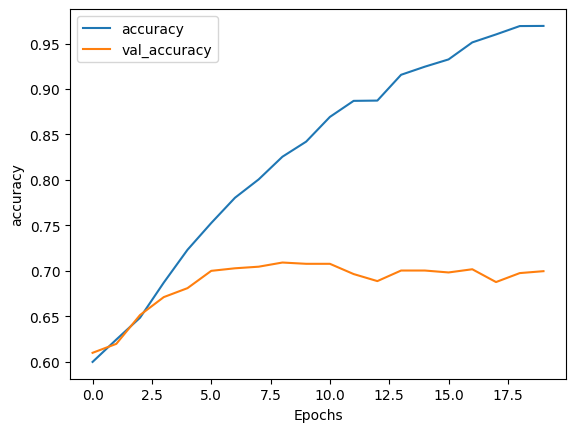

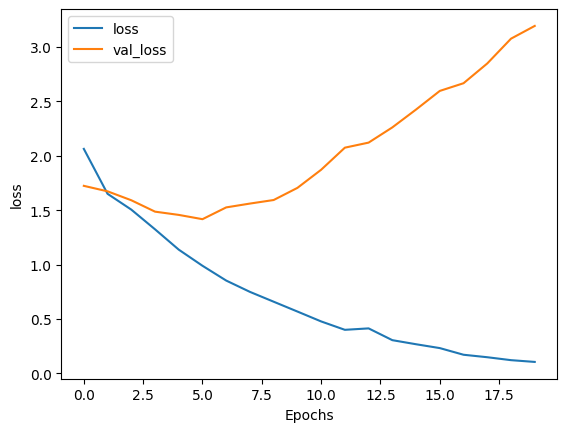

In [66]:
def plot_graphs(history, string):
 plt.plot(history.history[string])
 plt.plot(history.history['val_'+string])
 plt.xlabel("Epochs")
 plt.ylabel(string)
 plt.legend([string, 'val_'+string])
 plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Выводы
Анализируя графики зависимостей точности модели при обучении и проверке можно сделать вывод что модель может предсказать результат на реальных данных с вероятностью не более 70 процентов. Думаю это связано с наличием в тексте пустых слов, которые не несут большой смысловой нагрузки (я их не убрал из такста, таки слова как предлоги и др.). При этом на мой взгляд при длительном обучении модели происходит переобучение, о чем говрорит возрастьание потерь на следующем графике.

In [68]:
check_descriptions = []
check_padded = []
check_labels = []
for i in range(3):
    index=random.randint(0,len(validation_descriptions))
    check_descriptions.append(validation_descriptions[index])
    check_padded.append(validation_padded[index])
    check_labels.append(validation_labels[index])


In [84]:
check_padded=np.array(check_padded)
predictions = model.predict(check_padded)
print("predictions shape:", predictions.shape)



1/1 [==============================] - 0s 75ms/step
predictions shape: (3, 161)


In [124]:
def custom_key(val): 
    return val[0] 

result_dict = []
for one_predict in predictions:
    one_dict = []
    for index, values in enumerate(one_predict):              
        one_dict.append((values,index))
    one_dict.sort(key=custom_key,reverse=True)
    result_dict.append(one_dict)
    print(one_dict[:6])



java
[(1.0, 1), (7.8134486e-09, 15), (1.1740338e-09, 30), (5.8105026e-10, 42), (6.821221e-11, 21), (3.2472698e-11, 5)]
[(0.99999535, 2), (3.2718517e-06, 32), (1.3787542e-06, 5), (9.90833e-08, 29), (6.007766e-09, 70), (5.2377986e-09, 72)]
[(0.99999964, 1), (2.6756257e-07, 15), (1.3108223e-07, 42), (5.315497e-09, 12), (3.2622767e-09, 44), (3.0103988e-09, 14)]


In [135]:
key_list = list(label_dictionary.keys())
val_list = list(label_dictionary.values())
for index, messege in enumerate(check_descriptions):
    print('Тест:', index+1)
    print('Первоначальный запрос:', messege)
    print('По результам нейронной сети данное собщение относиться к группе:', result_dict[index][0][1], 'с вероятностью: ', result_dict[index][0][0])
    print('Истинная категория:', check_labels[index], 'Полученная категория: ', result_dict[index][0][1])
    print('Категрия данного вердикта по классификатору:', key_list[val_list.index(result_dict[index][0][1])])
    print('')
    print('------------------------')


Тест: 1
Первоначальный запрос: Необходимо отмыть от надписей и рисунков афишу рядом с домом 5Б проспекта Ватутина (50.577139° 36.583421°).
По результам нейронной сети данное собщение относиться к группе: 1 с вероятностью:  1.0
Истинная категория: 1 Полученная категория:  1
Категрия данного вердикта по классификатору: Неудовлетворительное содержание фасадов зданий и сооружений, общественных мест

------------------------
Тест: 2
Первоначальный запрос: Наул. Есенина врайоне д.8 передперекрёстком с ул. Щорса в г.Белгороде установка дорожных знаков несоответствует требованиям п. 5.1.8 «ГОСТ Р 52289–2019. Национальный стандарт Российской Федерации. Технические средства организации дорожного движения. Правила применения дорожных знаков, разметки, светофоров, дорожных ограждений инаправляющих устройств» дорожный знак приоритета 2.4 «Уступи дорогу» должен быть установлен выше предписывающего дорожного знака 4.1.5. «Движение прямо и налево».Очередность размещения знаков разных групп наодной опо